# Grocery Store Sales - Time Series Forecasting(2)_Models

## 1.Introduction

Business problem: <br>
- Problem: As a large Ecuadorian-based grocery retailer, Corporación Favorita faces a significant challenge of accurately forecasting product demand to balance inventory levels. Overestimating leads to wastage of perishable goods, while underestimating results in stockouts and dissatisfied customers. Precise forecasting is crucial to optimize inventory, ensuring the availability of the right products at the right time and minimizing waste and revenue loss.
- Goal: To improve inventory management by accurately forecasting the unit sales for thousands of items sold at different Favorita stores, thus reducing food waste related to overstocking and enhancing customer satisfaction. 
- Challenge：Current subjective forecasting methods for retail have little data to back them up and are unlikely to be automated. The problem becomes even more complex as retailers <b>add new locations with unique needs, new products, ever-transitioning seasonal tastes, and unpredictable product marketing</b>.

Data Science problem (Define Project):
- Purpose of the project: To predict sales volumes ('sales') for each item from each product family ('family') at each store('store_nbr') in the period of 2017-08-16 to 2017-08-31 (the test dataset).<br> 
As the sales records in the test dataset are not known, we plan to split records as below:<br> 
*train *: 2013-01-01 to 2017-07-30 <br>
*validation *: 2017-07-31 to 2017-08-15<br>
*test *: 2017-08-16 to 2017-08-31
- Features: The training data includes dates, store('store_nbr') and product information('family'), whether that item was being promoted('onpromotion'), as well as the sales numbers('sales'). Additional files ('oil', 'transactions','holidays_events', 'stores' ) include supplementary information that may be useful in building your models.
- Time series : For the 54 stores and 33 families, there is a sale entry for each of their combination, totalling 1782 time series. Time series analysis will be performed on an average basis.
- Target: the sales volumne ('sales'). It can be viewed as a single series (single-output regression), or as 1782 time series (multi-output regression).
- Evaluation Metrics: Root Mean Squared Logarithmic Error (RMSLE).

## 2.Data preprocessing

In [1]:
import pandas as pd
import numpy as np
import os
import joblib
import math
import random
import pickle
import datetime as datetime
# !pip install prophet
from prophet import Prophet

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import periodogram
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit, train_test_split

from sklearn.metrics import mean_squared_log_error

from warnings import simplefilter
simplefilter("ignore")

Importing plotly failed. Interactive plots will not work.


In [2]:
pd.reset_option('display.max_columns')

### load data
- *train.csv*: The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
- *store_nbr* identifies the store at which the products are sold.
- *family* identifies the type of product sold.
- *sales* gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips). 
- *onpromotion*: gives the total number of items in a product family that were being promoted at a store at a given date.


- *test.csv*:  The test data, having the same features as the training data. You will predict the target sales for the dates in this file. The dates in the test data are for the 15 days after the last date in the training data.

- *holidays_events.csv*:  Holidays and Events, with metadata. NOTE: Pay special attention to the `transferred` column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge. Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

- *Additional Notes*:  Wages in the public sector are paid `every two weeks` on the 15 th and on the last day of the month. Supermarket sales could be affected by this. A magnitude `7.8 earthquake` struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

In [3]:
os.listdir('data') #check all the data files in the project, there are 6

['holidays_events.csv',
 'oil.csv',
 'sample_submission.csv',
 'stores.csv',
 'test.csv',
 'train.csv',
 'transactions.csv']

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
holidays_events = pd.read_csv('data/holidays_events.csv')
oil = pd.read_csv('data/oil.csv') # time range 2013-01-01 to 2017-08-31, daily crude oil West Texas Intermediate -Cushing, Oklahoma
transactions = pd.read_csv('data/transactions.csv') #time range 2013-01-01 to 2017-08-15
stores = pd.read_csv('data/stores.csv')

In [5]:
# Convert the 'date' column to datetime type
train.date = pd.to_datetime(train.date)
train['date'] = train.date.dt.to_period('D')   #have to do this, or dp.out_of_sample(steps=16) ->time_step
test.date = pd.to_datetime(test.date)
test['date'] = test.date.dt.to_period('D')
transactions.date = pd.to_datetime(transactions.date)
holidays_events.date = pd.to_datetime(holidays_events.date)

In [6]:
# clean up each file by assigning types and re-organizing indices, first train
# have to do this code, or cant't join test.id to y_summit successfully.
train = train.astype({'store_nbr': 'category',
                      'family': 'category',
                      'sales': 'float32',
                      'onpromotion': 'uint64'})
test = test.astype({'store_nbr': 'category',
                      'family': 'category',                      
                      'onpromotion': 'uint64'})

holidays_events = holidays_events.astype({
    'type': 'category',
    'locale': 'category',
    'locale_name': 'category',
    'description': 'category',
    'transferred': 'bool'
})

In [7]:
# Setting MultiIndex to make unique identifiers for each 'sales' item
train = train.set_index(['date', 'family', 'store_nbr']).sort_index()
test = test.set_index(['date', 'family', 'store_nbr']).sort_index()
holidays_events = (holidays_events.set_index('date')  #sets the 'date' column as the index
                   .to_period('D'))  #converts the index to a PeriodIndex with a daily frequency ('D')

In [8]:
X_train = train.loc[:'2017-07-30']   # train: 2013-01-01 to 2017-07-30
y_train = (X_train
           .unstack(['family', 'store_nbr'])
           .loc[:,"sales"]
          )

X_val =train.loc['2017-07-31':]      # val: 2017-07-31 to 2017-08-15
y_val = (X_val
           .unstack(['family', 'store_nbr'])
           .loc[:,"sales"]
          )

X_test = test.copy()                # test: 2017-08-16 to 2017-08-31

# Simple index with dates
index_ = X_train.index.get_level_values('date').unique() 

### *A theoretical issue*: **MultiIndex**

In time series, we analyze temporal dependencies. We compare the state of the Target variable with itself at a different point in time. This implies a couple of things:

- Each unit of the target should be a time-indexed series containing a slice of information about the state of all objects at that moment. Thus, in each column, we will have a time-varying value of the same object. In other words, frozen pizza and bicycles will be in separate (independent) columns, and each of these columns will contain a time series of changes in the studied parameter (price, units sold, etc.).

- To ensure that pizza stays with pizza and bikes with bikes, the data needs to be grouped by all categorical features in the dataset and spread out into a 'wide' series. Then this series is taken at each new moment, and the DataFrame is configured line by line. This is our `y`

This is where a MultiIndex comes in handy.

1. You add all your categorical features to the index and make it a MultiIndex:  
`.set_index(['date', 'family', 'store_nbr']`. <br>
*Now, your index has 3 columns, and your TARGET is 1 value per row.*

2. You pivot all index levels but 'date' from columns (long format) to rows (wide format). Note that it's still the same MultiIndex!
`unstack(['family', 'store_nbr'])` <br>
*Now, your index has 1 column 'date' and 2 rows and your TARGET is **1782** values per row* 

Why is this helpful? Because now we have a standard **'dates'** column, just like any other time series. <br>
When you query `.loc['2017-01-01']`, you obtain an array of 1782 values, the result of 54 commodity families being sold in 33 stores, each uniquely indexed.

And what's in the columns? Precisely! Time-dependent changes for each of the 1782 values.<br> 
So, the Linear Regression model interprets 1782 separate vectors, which essentially means that we have 1782 different Linear Regression models in one.

In [ ]:
# # code Notes:
# X_train.index.get_level_values(0).min()
# X_train.index.get_level_values(0).max()

# # X_train with a MultiIndex consisting of 'date', 'family', and 'store_nbr'
# # Select before 2017-07-30
# X_train = train.loc[:'2017-07-30']
# # Select one specific family and store_nbr across all dates
# X_train.loc[(slice(None), 'selected_family', 'selected_store_nbr'), :]

# #After .unstack(['family', 'store_nbr']) columns from the MultiIndex.Here df has "date" index and one column with multiindex('family', 'store_nbr')
# #  -->e.g. y_train, y_train_pred.
# # Select one specific family and store_nbr across all dates
# y_train.loc[:, ('AUTOMOTIVE', slice(None))]
# # Get all unique values of the 'family' level
# y_train.columns.get_level_values('family').unique()

# #Self-study code notes: y_train has 'date' as index, has a column with multiindex of 'family' and 'store_nbr'
# #get mean across stores for each family
# y_train.groupby(level='family', axis=1).mean()
# # Select 'BOOKS' and get mean across stores for each date.
# y_train.loc[:, ('BOOKS', slice(None))].mean(axis=1)  #axis=1 : Calculate the mean for each row


### Visualization Settings

In [9]:
# matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="#556B2F",          
    style=".-",               
    markeredgecolor="#4169E1", 
    markerfacecolor="#8B0000", 
    legend=False              
)

%config InlineBackend.figure_format = 'retina'

## 3.Model Selection and Strategies for Forecasting

### Stretegies:
- 1) BASELINE MODEL: TREND (simple linear regression model)
- 2) STRATEGY I: Capture Seasonality
- 3) STRATEGY II: Boosted Hybrid Model
- 4) STRATEGY III: Stacked Hybrid Model
- 5) STRATEGY IV: Facebook Prophet

### 1)BASELINE MODEL: TREND (simple linear regression model)

In [11]:
#create trend features(Time-step feature) using DeterministicProcess. i.e. create a time dummy by counting out the length of the series(Time).
dp = DeterministicProcess(
    index = index_,     # dates from the training data        
    constant = True,    # dummy feature for the bias (y_intercept)
    order = 1,          # time-dummy (trend) #The order argument refers to polynomial order: 1(linear), 2(quadratic), 3(cubic), and so on.
    drop = True,        # drop terms if necessary to avoid collinearity          
)

X_time_train = dp.in_sample()  # `in_sample` creates features for the dates given in the `index` argument

# Create time-step features for validation set and test set
X_time = dp.out_of_sample(steps=32)   # 'out_of_sample (32)' means along the next 32 time-index labels ('days' in our case)
X_time.index.name = 'date'
X_time_val = X_time.loc[:'2017-08-15']
X_time_test = X_time.loc['2017-08-16':]

In [12]:
"""
y_train has a 'wide' format and the model learns to predict not just 1 value, but 1782 at once(pre date).
"""
base_model = LinearRegression (fit_intercept = False).fit(X_time_train, y_train)

# # Save the baseline model to a file named 'baseline_model.pkl'
# joblib.dump(base_model, 'baseline_model.pkl')

In [13]:
# Load the saved model from the file
# base_model = joblib.load('./baseline_model.pkl')
y_train_pred = pd.DataFrame(base_model.predict(X_time_train),               
                        index = X_time_train.index,      
                        columns = y_train.columns
                        ).clip(0.0)
rmsle_train = mean_squared_log_error(y_train, y_train_pred) ** 0.5
print(f'Train RMSLE: \033[1m{rmsle_train:.5f}\033[0m')

Train RMSLE: 1.18483


In [14]:
y_val_pred = pd.DataFrame(base_model.predict(X_time_val),               
                        index = X_time_val.index,      
                        columns = y_train.columns
                        ).clip(0.0)   # Clip the predicted values to ensure they are non-negative, as Mean Squared Logarithmic Error cannot be used when targets contain negative values.
rmsle_val = mean_squared_log_error(y_val, y_val_pred) ** 0.5
print(f'Validation RMSLE: \033[1m{rmsle_val:.5f}\033[0m')

Validation RMSLE: 0.59508


In [15]:
y_test_pred = pd.DataFrame(base_model.predict(X_time_test),               
                        index = X_time_test.index,      
                        columns = y_train.columns).clip(0.0)

In [17]:
# Compute Validation RMSLE for each family separately
rmsle_val_per_family = {}
## Get all unique values of the 'family' level. y_val has 'date' as index, has column of multiindex(family, store_nbr)
for f in list(y_val.columns.get_level_values('family').unique()):
    # select data for each family 
    y_val_family = y_val.loc[:, (f, slice(None))]
    y_val_pred_family = y_val_pred.loc[:, (f, slice(None))]
    rmsle_val_per_family[f] = np.sqrt(mean_squared_log_error(y_val_family, y_val_pred_family))

# Convert dictionary to DataFrame for easier analysis (optional)
rmsle_val_per_family_df = pd.DataFrame.from_dict(rmsle_val_per_family, orient='index', columns=['RMSLE'])
rmsle_val_per_family_df.sort_values(by=['RMSLE'])

RMSLE
BOOKS                       0.295948
GROCERY I                   0.310406
BABY CARE                   0.339336
DELI                        0.341510
BREAD/BAKERY                0.346434
BEVERAGES                   0.371703
DAIRY                       0.373175
PERSONAL CARE               0.378673
CLEANING                    0.390294
MEATS                       0.397093
POULTRY                     0.400054
HOME APPLIANCES             0.400095
PRODUCE                     0.422130
HOME CARE                   0.435091
PREPARED FOODS              0.476962
EGGS                        0.484587
LAWN AND GARDEN             0.514741
PET SUPPLIES                0.529723
HARDWARE                    0.576277
AUTOMOTIVE                  0.581158
SEAFOOD                     0.598389
MAGAZINES                   0.599397
PLAYERS AND ELECTRONICS     0.602451
HOME AND KITCHEN II         0.615111
BEAUTY                      0.623091
GROCERY II                  0.624831
HOME AND KITCHEN I          0.677927
FROZEN FOODS                0.700544
LINGERIE                    0.701520
CELEBRATION                 0.741686
LADIESWEAR                  0.769261
LIQUOR,WINE,BEER            0.823186
SCHOOL AND OFFICE SUPPLIES  1.598374

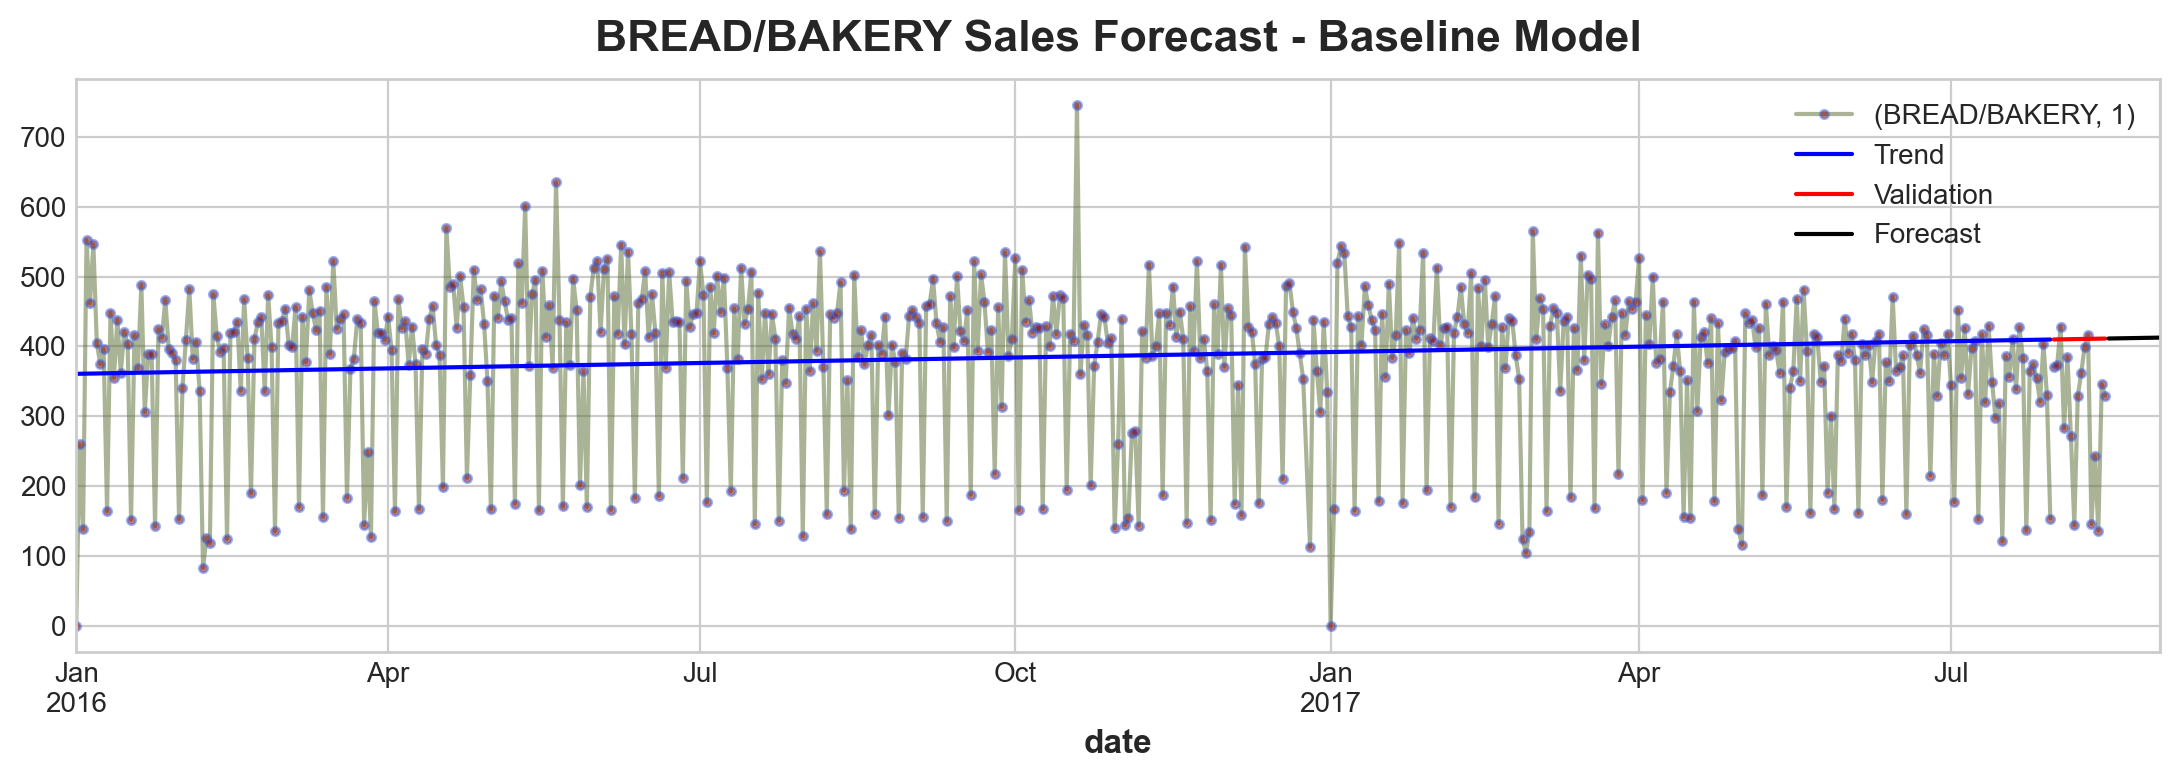

In [18]:
"""
Visualizing TREND against sales 
"""
# plot 'BREAD/BAKERY' as an example, as it has more frequent sales.
ax = y_train.loc["2016-01-01":, ('BREAD/BAKERY', 1)].plot(**plot_params, alpha=0.5)
y_train_pred.loc["2016-01-01":, ('BREAD/BAKERY', 1)].plot(ax=ax, color="blue", label="Trend")
y_val.loc[:, ('BREAD/BAKERY', 1)].plot(**plot_params, ax=ax, alpha=0.5, label="")
y_val_pred.loc[:, ('BREAD/BAKERY', 1)].plot(ax=ax, color="red", label ="Validation")
y_test_pred.loc[:, ('BREAD/BAKERY', 1)].plot(ax=ax, color="black", label= "Forecast")
ax.set_title (f'BREAD/BAKERY Sales Forecast - Baseline Model')
ax.legend()

In [63]:
# submission_0 = (y_test_pred
#             .stack(['family', 'store_nbr'])
#             .to_frame()
#             .join(test.id)   # Associate predictions with original IDs 
#             .rename(columns = {0:'sales'})
#             .reset_index(drop=True)
#             .reindex(columns = ['id','sales'])
#             )
# submission_0.to_csv('/kaggle/working/submission.csv', index=False)
# # # Notes: Retrieve the original IDs
# # original_ids = original_data.index
# # # Associate predictions with original IDs
# # predictions_with_ids = pd.DataFrame({'id': original_ids, 'y_pred': y_pred})

### 2).STRATEGY I: Capture Seasonality

#### Capture Seasons with Fourier Features

In [16]:
def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

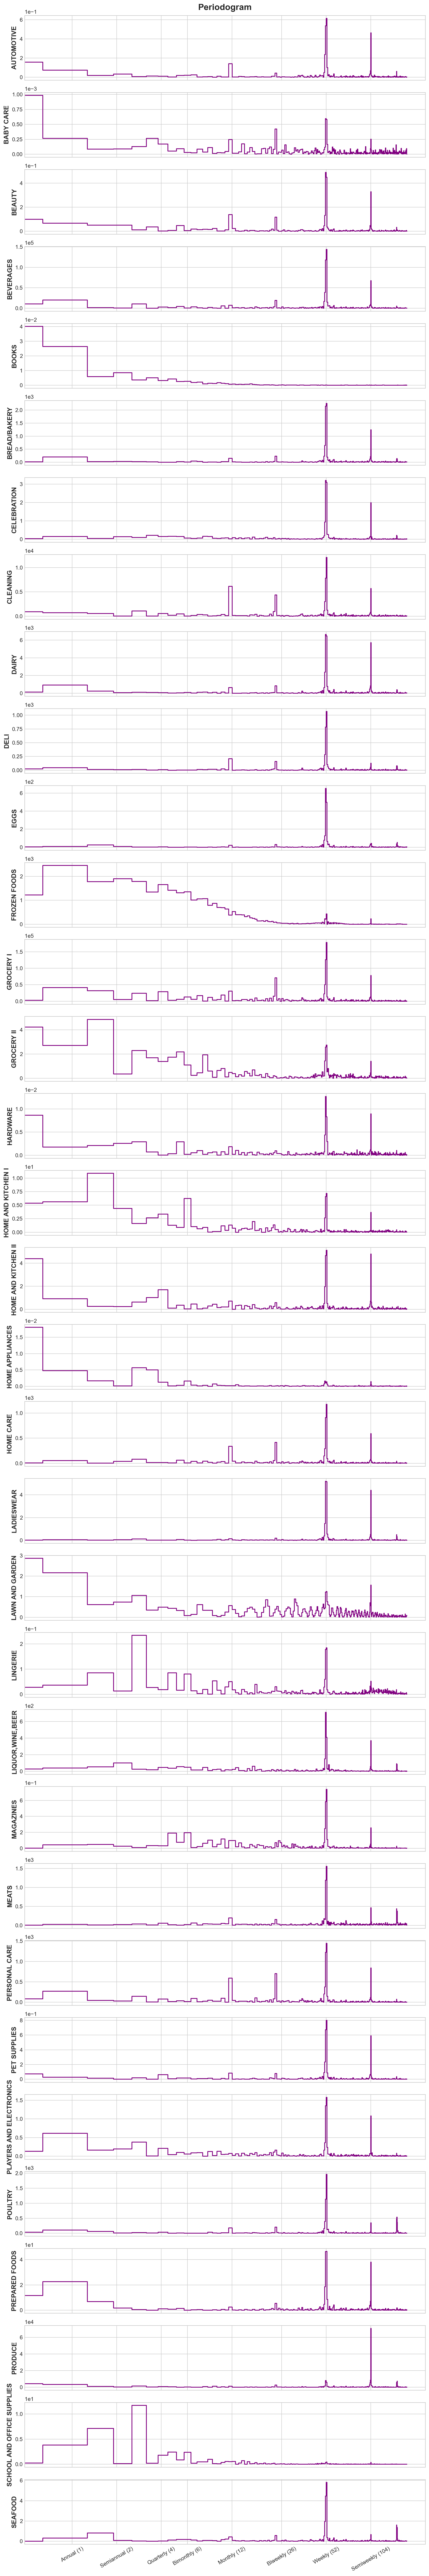

In [17]:
#plot Periodogram for family-averaged sales across all stores from "2016-01-01" till "2017-07-30"
y_family_average = y_train["2016-01-01":].groupby(level='family', axis=1).mean()

fig, axs = plt.subplots(33, 1, figsize = (11, 66), sharex = True)
for column, ax in zip(y_family_average.columns, axs):
    plot_periodogram(y_family_average[column], ax = ax)
    ax.set_ylabel(column)
    ax.set_title('')
axs[0].set_title('Periodogram')
plt.show()

In [18]:
fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality            
dp_fourier = DeterministicProcess(
            index = index_,
            constant=False,             
            order=1,         # trend (order 1 means linear)      
            seasonal=True,   # weekly seasonality (indicators)                                 
            additional_terms=[fourier],     # annual seasonality (fourier)
            drop=True     # drop terms to avoid collinearity
)
X_fourier_train = dp_fourier.in_sample()   # create features for dates in X_train
X_fourier = dp_fourier.out_of_sample(steps=32)   # 'out_of_sample (32)' means along the next 32 time-index labels ('days' in our case)
X_fourier_val = X_fourier.loc[:'2017-08-15']
X_fourier_test = X_fourier.loc['2017-08-16':]

In [19]:
model = LinearRegression (fit_intercept = False).fit(X_fourier_train, y_train)


In [20]:
y_train_pred = pd.DataFrame(model.predict(X_fourier_train),               
                        index = X_fourier_train.index,      
                        columns = y_train.columns
                        ).clip(0.0)
rmsle_train = mean_squared_log_error(y_train, y_train_pred) ** 0.5
print(f'Train RMSLE: \033[1m{rmsle_train:.5f}\033[0m')

Train RMSLE: 1.16590


In [21]:
y_val_pred = pd.DataFrame(model.predict(X_fourier_val),               
                        index = X_fourier_val.index,      
                        columns = y_train.columns
                        ).clip(0.0)   # Clip the predicted values to ensure they are non-negative, as Mean Squared Logarithmic Error cannot be used when targets contain negative values.
rmsle_train = mean_squared_log_error(y_val, y_val_pred) ** 0.5
print(f'Validation RMSLE: \033[1m{rmsle_train:.5f}\033[0m')

Validation RMSLE: 0.58797


In [22]:
y_test_pred = pd.DataFrame(model.predict(X_fourier_test),               
                        index = X_fourier_test.index,      
                        columns = y_train.columns).clip(0.0)

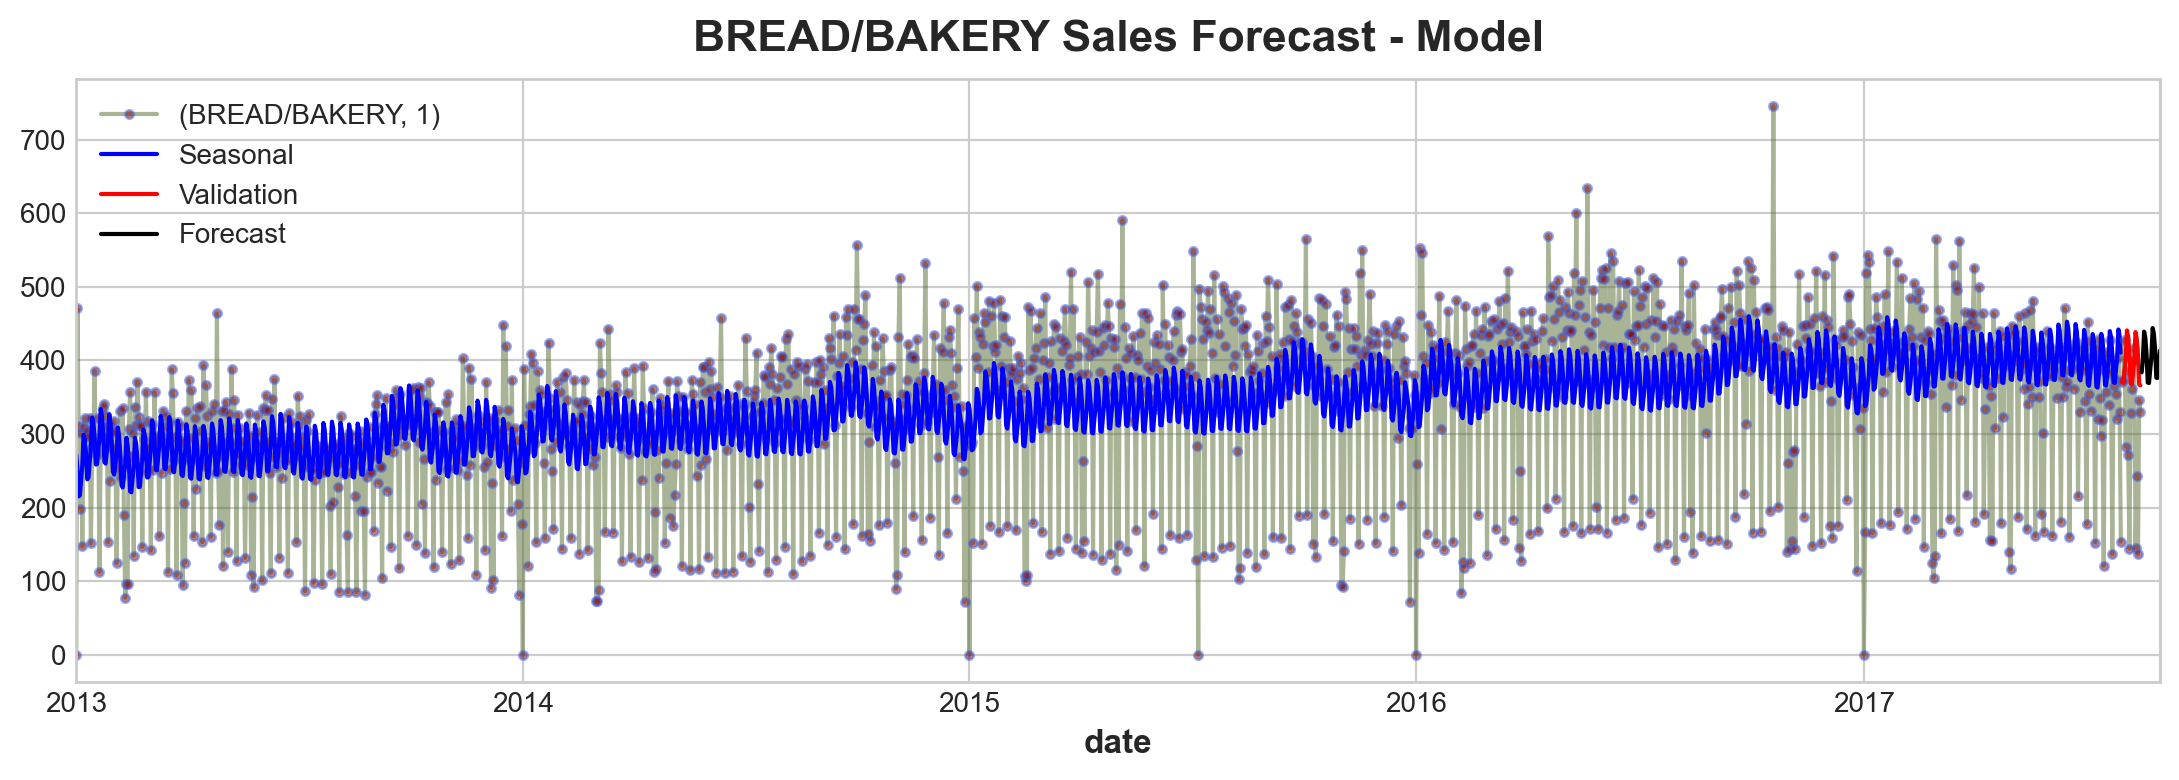

In [73]:
"""
Visualizing Seasonal against sales 
"""
# plot 'BREAD/BAKERY' as an example, as it has more frequent sales.
ax = y_train.loc[:, ('BREAD/BAKERY', 1)].plot(**plot_params, alpha=0.5)
y_train_pred.loc[:, ('BREAD/BAKERY', 1)].plot(ax=ax, color="blue", label="Seasonal")
y_val.loc[:, ('BREAD/BAKERY', 1)].plot(**plot_params, ax=ax, alpha=0.5, label="")
y_val_pred.loc[:, ('BREAD/BAKERY', 1)].plot(ax=ax, color="red", label ="Validation")
y_test_pred.loc[:, ('BREAD/BAKERY', 1)].plot(ax=ax, color="black", label= "Forecast")
ax.set_title (f'BREAD/BAKERY Sales Forecast - Model')
ax.legend()

#### Capture Seasons with day_of_week (indicators)

In [23]:
"""
Add OHE matrix for day of the week
"""

day_of_week = pd.Series(X_fourier_train.index.dayofweek, index = index_)
X_day_of_week = pd.get_dummies(day_of_week, prefix = 'day_of_week')
X_seasonal_train = pd.concat([X_fourier_train, X_day_of_week], axis=1)
# # Check
# X_seasonal_train

day_of_week = pd.Series(X_fourier_val.index.dayofweek, index = X_fourier_val.index)
X_day_of_week = pd.get_dummies(day_of_week, prefix = 'day_of_week')
X_seasonal_val = pd.concat([X_fourier_val, X_day_of_week], axis=1)

day_of_week = pd.Series(X_fourier_test.index.dayofweek, index = X_fourier_test.index)
X_day_of_week = pd.get_dummies(day_of_week, prefix = 'day_of_week')
X_seasonal_test = pd.concat([X_fourier_test, X_day_of_week], axis=1)

In [24]:
model = LinearRegression (fit_intercept = False).fit(X_seasonal_train, y_train)


In [25]:
y_train_pred = pd.DataFrame(model.predict(X_seasonal_train),               
                        index = X_seasonal_train.index,      
                        columns = y_train.columns
                        ).clip(0.0)
rmsle_train = mean_squared_log_error(y_train, y_train_pred) ** 0.5
print(f'Train RMSLE: \033[1m{rmsle_train:.5f}\033[0m')

Train RMSLE: 1.14066


In [26]:
y_val_pred = pd.DataFrame(model.predict(X_seasonal_val),               
                        index = X_seasonal_val.index,      
                        columns = y_train.columns
                        ).clip(0.0)   # Clip the predicted values to ensure they are non-negative, as Mean Squared Logarithmic Error cannot be used when targets contain negative values.
rmsle_train = mean_squared_log_error(y_val, y_val_pred) ** 0.5
print(f'Validation RMSLE: \033[1m{rmsle_train:.5f}\033[0m')

Validation RMSLE: 0.56965


In [27]:
y_test_pred = pd.DataFrame(model.predict(X_seasonal_test),               
                        index = X_seasonal_test.index,      
                        columns = y_train.columns).clip(0.0)

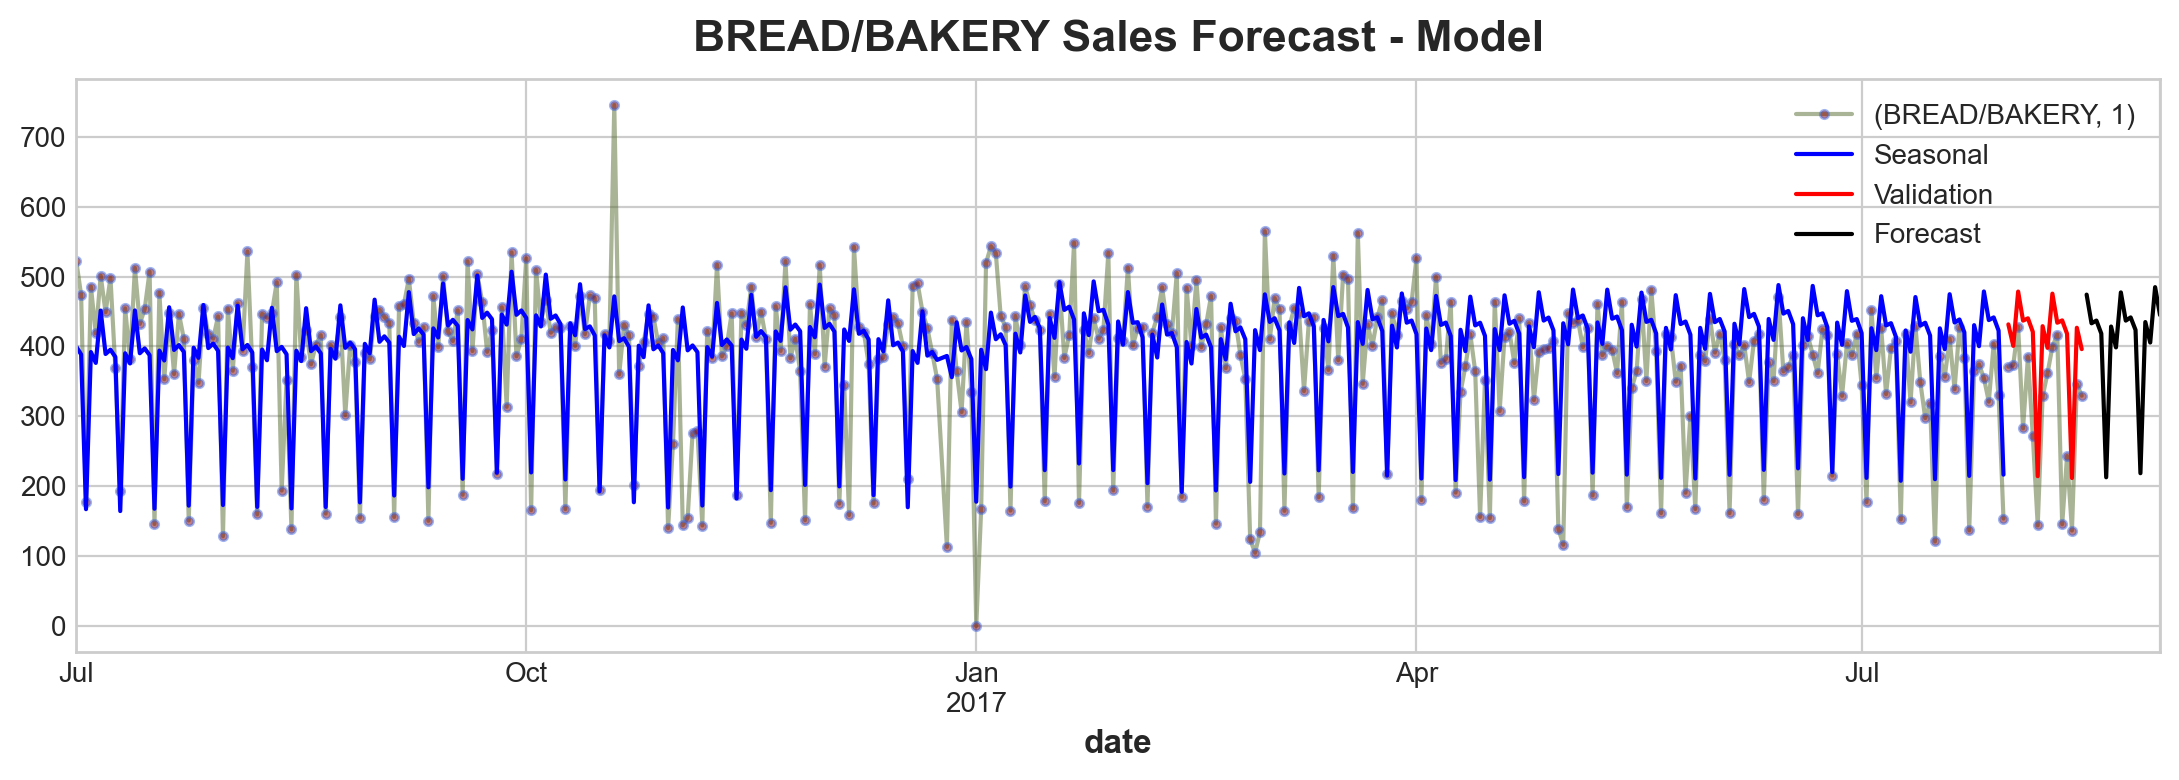

In [28]:
"""
Visualizing Seasonal against sales 
"""
# plot 'BREAD/BAKERY' as an example, as it has more frequent sales.
ax = y_train.loc["2016-07-01":, ('BREAD/BAKERY', 1)].plot(**plot_params, alpha=0.5)
y_train_pred.loc["2016-07-01":, ('BREAD/BAKERY', 1)].plot(ax=ax, color="blue", label="Seasonal")
y_val.loc[:, ('BREAD/BAKERY', 1)].plot(**plot_params, ax=ax, alpha=0.5, label="")
y_val_pred.loc[:, ('BREAD/BAKERY', 1)].plot(ax=ax, color="red", label ="Validation")
y_test_pred.loc[:, ('BREAD/BAKERY', 1)].plot(ax=ax, color="black", label= "Forecast")
ax.set_title (f'BREAD/BAKERY Sales Forecast - Model')
ax.legend()

#### Capture Seasons with holidays

*Pay special attention to the 'transferred' column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday.*

In [ ]:
"""
NOTE: This feature covers New Year.
"""
holidays = (holidays_events  
            .query("transferred == False")                            # drop the transferred holidays, since they are regular days
            .query("locale == 'National'")                            # keep the National holidays only, since the location of the stores is unknown
            .loc[:,'description']                                     # keep one column with holidays names
            .to_frame().assign(description=lambda x: x.description.cat.remove_unused_categories())
           )
duplicated_dates = holidays.index.duplicated(keep='first')
holidays = holidays[~duplicated_dates]

X_holidays = pd.get_dummies (holidays)
X_seasonal_train = X_seasonal_train.join(X_holidays, on='date', how='left').fillna(0.0)   

X_seasonal_val.index.name = 'date'
X_seasonal_val = X_seasonal_val.join(X_holidays, on='date', how='left').fillna(0.0)
X_seasonal_test.index.name = 'date'
X_seasonal_test = X_seasonal_test.join(X_holidays, on='date', how='left').fillna(0.0)

In [30]:
model = LinearRegression (fit_intercept = False).fit(X_seasonal_train, y_train)
# joblib.dump(model, 'seasonal_model.pkl')

In [33]:

y_train_pred = pd.DataFrame(model.predict(X_seasonal_train),               
                        index = X_seasonal_train.index,      
                        columns = y_train.columns
                        ).clip(0.0)
rmsle_train = mean_squared_log_error(y_train, y_train_pred) ** 0.5
print(f'Train RMSLE: \033[1m{rmsle_train:.5f}\033[0m')

Train RMSLE: 1.10332


In [34]:
y_val_pred = pd.DataFrame(model.predict(X_seasonal_val),               
                        index = X_seasonal_val.index,      
                        columns = y_train.columns
                        ).clip(0.0)   # Clip the predicted values to ensure they are non-negative, as Mean Squared Logarithmic Error cannot be used when targets contain negative values.
rmsle_train = mean_squared_log_error(y_val, y_val_pred) ** 0.5
print(f'Validation RMSLE: \033[1m{rmsle_train:.5f}\033[0m')

Validation RMSLE: 0.57279


In [35]:
y_test_pred = pd.DataFrame(model.predict(X_seasonal_test),               
                        index = X_seasonal_test.index,      
                        columns = y_train.columns).clip(0.0)

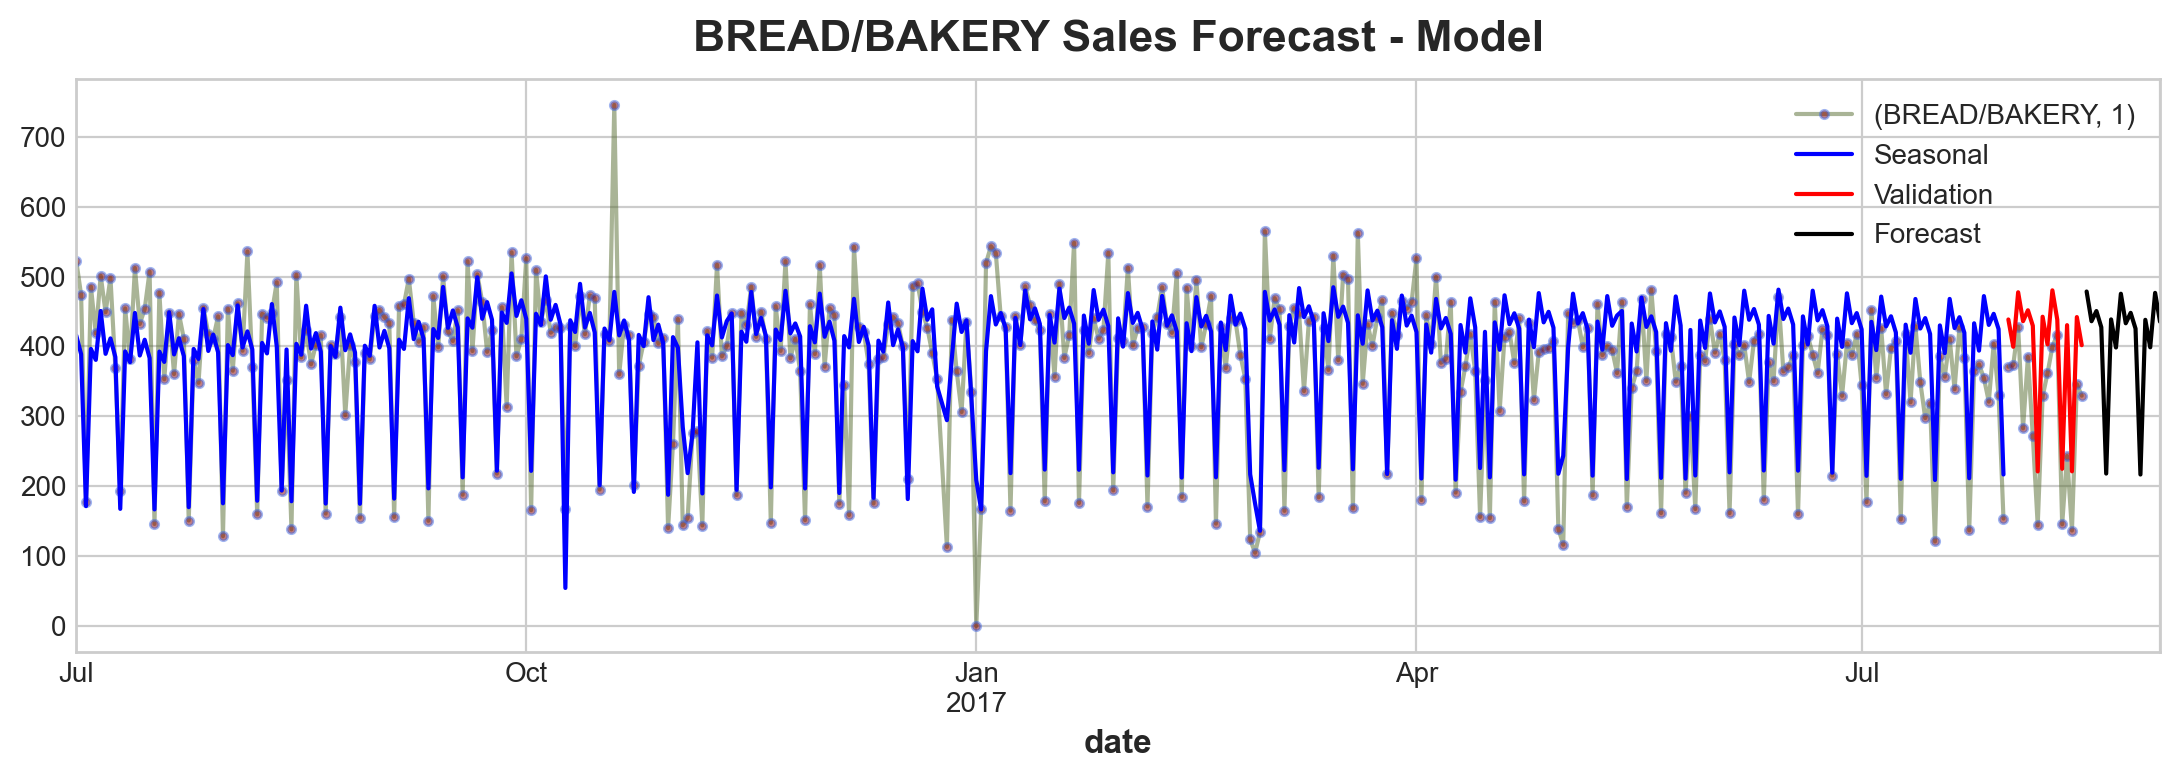

In [97]:
"""
Visualizing Seasonal against sales 
"""
# plot 'BREAD/BAKERY' as an example, as it has more frequent sales.
ax = y_train.loc["2016-07-01":, ('BREAD/BAKERY', 1)].plot(**plot_params, alpha=0.5)
y_train_pred.loc["2016-07-01":, ('BREAD/BAKERY', 1)].plot(ax=ax, color="blue", label="Seasonal")
y_val.loc[:, ('BREAD/BAKERY', 1)].plot(**plot_params, ax=ax, alpha=0.5, label="")
y_val_pred.loc[:, ('BREAD/BAKERY', 1)].plot(ax=ax, color="red", label ="Validation")
y_test_pred.loc[:, ('BREAD/BAKERY', 1)].plot(ax=ax, color="black", label= "Forecast")
ax.set_title (f'BREAD/BAKERY Sales Forecast - Model')
ax.legend()

In [ ]:
# submission_1 = (y_test_pred
#             .stack(['family', 'store_nbr'])
#             .to_frame()
#             .join(test.id)
#             .rename(columns = {0:'sales'})
#             .reset_index(drop=True)
#             .reindex(columns = ['id','sales'])
#             )
# # submission_1.to_csv('/kaggle/working/submission.csv', index=False)

### 3).STRATEGY II: Boosted Hybrid Model

In [97]:
"""
While the linear regression algorithm is capable of multi-output regression, 
the XGBoost algorithm is not. To predict multiple series at once with XGBoost, 
we'll instead convert these series from wide format, with one time series per column, 
to long format, with series indexed by categories along rows.
"""

class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method
        
    def fit(self, X_1, X_2, y):
        self.model_1.fit(X_1, y)
        y_fit = pd.DataFrame(                          # make predictions with self.model_1
                    self.model_1.predict(X_1),
                    index=X_1.index, 
                    columns=y.columns
        )
        y_resid = y - y_fit                             # compute residuals
        y_resid = y_resid.stack([0,1])                  # wide to long. (level=[0,1]) - to pivot both 'family' and 'store_nbr'
        
        # X_2_train, X_2_val, y_resid_train, y_resid_val = train_test_split(X_2, y_resid, test_size=0.2, shuffle=False)

        self.model_2.fit(X_2, y_resid)
                        # X_2_train, y_resid_train,     # fit self.model_2 on residuals
                        #  early_stopping_rounds=5,      # This is an XGB feature
                        #  eval_set=[(X_2_val, y_resid_val)], # that works in pair with this one
                        #  verbose=False)

        self.y_columns = y.columns                     # Save column names for predict method
        self.y_fit = y_fit                             # Save data
        self.y_resid = y_resid
        
        
    def predict(self, X_1, X_2):
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index, 
            columns=self.y_columns,
        )
        y_pred = y_pred.stack([0,1])
        y_pred += self.model_2.predict(X_2)
        
        return y_pred

In [98]:
'''
As soon as we have 'early_stopping' hyperparameter for XGB, 
the value of 'n_estimators' becomes less significant. 
'''
model_BH = BoostedHybrid(
            model_1=LinearRegression(fit_intercept = False),
            model_2=XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)
)

In [105]:
"""
So that XGBoost can learn to distinguish between FAMILIES and STORES, 
we'll duplicate these levels of MultiIndex with categorical features with a label encoding. 
"""
# Prepare X_2
def prepare_X_2(X= X_train):
    X_2 = X[['onpromotion']]
    le_family = LabelEncoder()
    X_2['family_fact'] = X_2.index.get_level_values('family')
    X_2['family_fact'] = le_family.fit_transform(X_2['family_fact'])
    X_2['store_fact'] = X_2.index.get_level_values('store_nbr').astype(int)
    return X_2

In [106]:
X_2_train = prepare_X_2(X_train)
X_2_val = prepare_X_2(X_val)
X_2_test = prepare_X_2(X_test)

In [99]:
model_BH.fit(X_seasonal_train, X_2_train, y_train)


In [104]:
# joblib.dump (model_BH, 'BoostedHybrid-without split.pkl')
# model_BH = joblib.load('BoostedHybrid-without split.pkl')

['BoostedHybrid-without split.pkl']

In [100]:
# model_BH = joblib.load('BoostedHybrid.pkl')
y_BH_fit = model_BH.predict(X_seasonal_train, X_2_train).clip(0.0)

In [101]:
rmsle_train = mean_squared_log_error(y_train.stack(level=[0,1]), y_BH_fit) ** 0.5
print(f'Train RMSLE: \033[1m{rmsle_train:.5f}\033[0m')

Train RMSLE: 1.10443


In [108]:
y_BH_val = model_BH.predict(X_seasonal_val, X_2_val).clip(0.0)
rmsle_train = mean_squared_log_error(y_val.stack(level=[0,1]), y_BH_val) ** 0.5
print(f'Train RMSLE: \033[1m{rmsle_train:.5f}\033[0m')

Train RMSLE: 0.64062


In [109]:
y_BH_test = model_BH.predict(X_seasonal_test, X_2_test).clip(0.0)

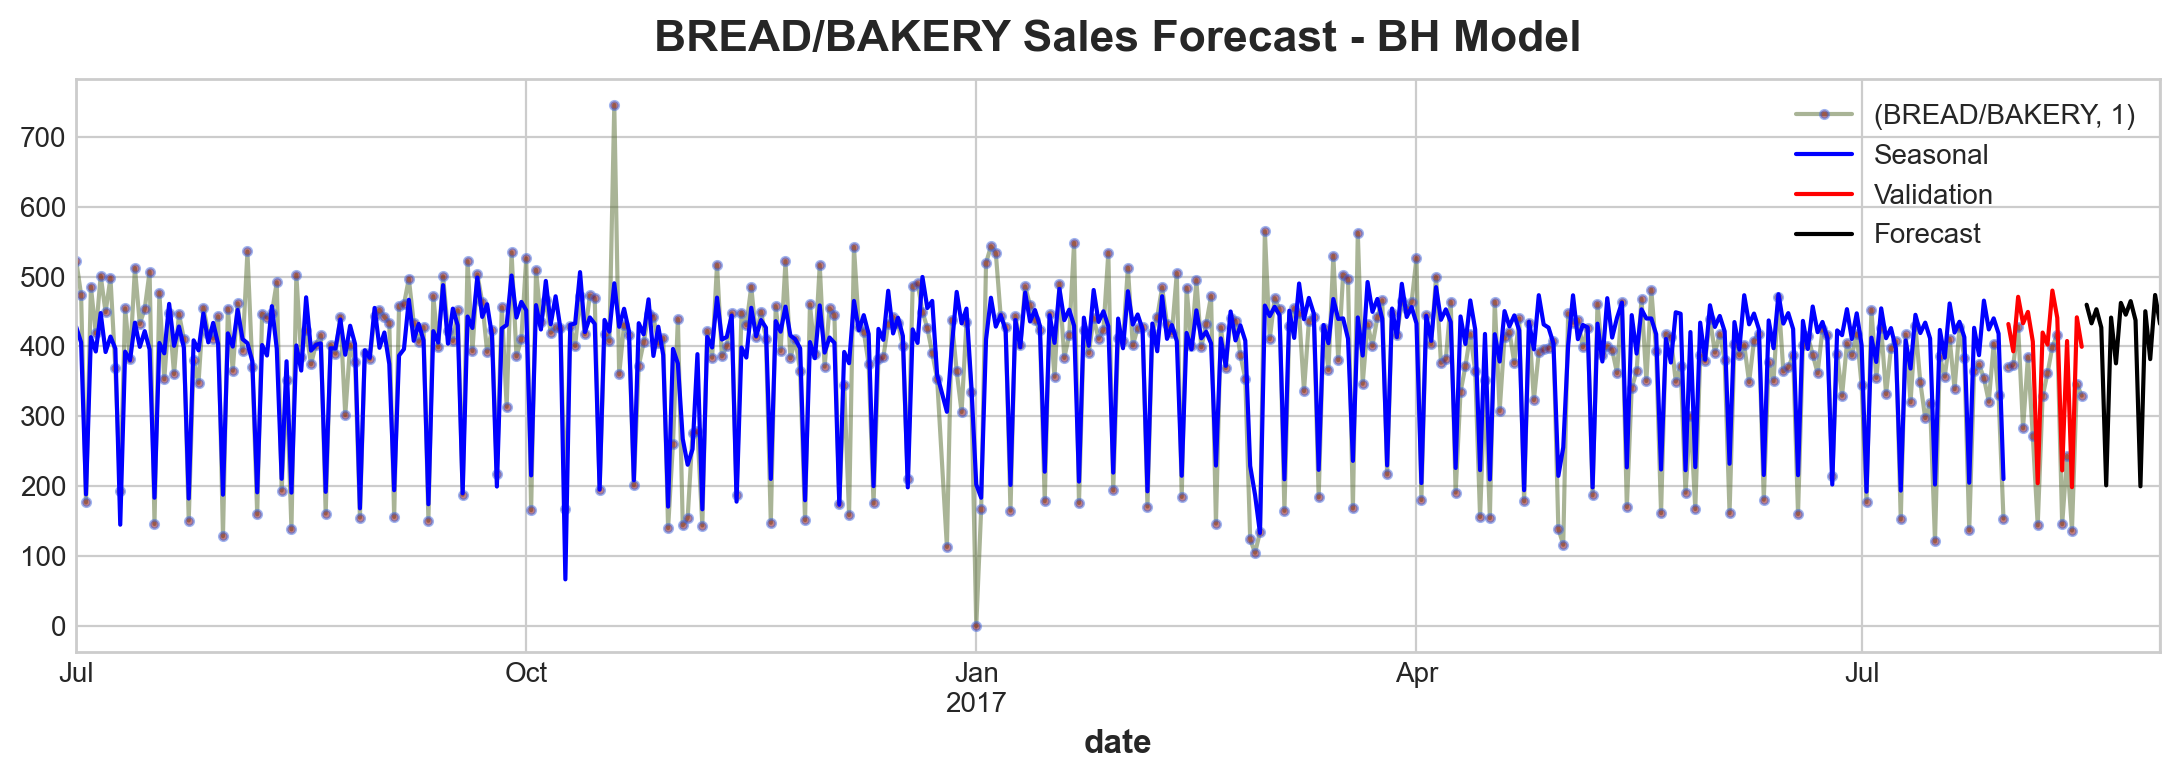

In [111]:
"""
Visualizing Seasonal against sales 
"""
# plot 'BREAD/BAKERY' as an example, as it has more frequent sales.
ax = y_train.loc["2016-07-01":, ('BREAD/BAKERY', 1)].plot(**plot_params, alpha=0.5)
(y_BH_fit.unstack(level=[1,2])).loc["2016-07-01":, ('BREAD/BAKERY', 1)].plot(ax=ax, color="blue", label="Seasonal")
y_val.loc[:, ('BREAD/BAKERY', 1)].plot(**plot_params, ax=ax, alpha=0.5, label="")
y_BH_val.unstack(level=[1,2]).loc[:, ('BREAD/BAKERY', 1)].plot(ax=ax, color="red", label ="Validation")
y_BH_test.unstack(level=[1,2]).loc[:, ('BREAD/BAKERY', 1)].plot(ax=ax, color="black", label= "Forecast")
ax.set_title (f'BREAD/BAKERY Sales Forecast - BH Model')
ax.legend()

In [ ]:
# submission_2 = (y_BH_test 
#             .to_frame()
#             .join(test.id)
#             .rename(columns = {0:'sales'})
#             .reset_index(drop=True)
#             .reindex(columns = ['id','sales'])
#             )
# # submission_2.to_csv('/kaggle/working/submission.csv', index=False)

### 4).STRATEGY III: Stacked Hybrid Model

In [37]:
''' 
Boosted Hybrid model:multiple base models are trained sequentially, where each subsequent model focuses on learning from the errors made by the previous models. 
Stacked Hybrid model: include model_1's prediction as a feature in X_2_train instead of subtracting it from y_train.
'''

class StackedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method
        
    def fit(self, X_1, X_2, y):
        self.model_1.fit(X_1, y)
        y_fit = pd.DataFrame(                          
                    self.model_1.predict(X_1),
                    index=X_1.index, 
                    columns=y.columns
        )
    
        y_long = y_fit.stack(level=[0,1])              
        
        X_2 = pd.concat([X_2, y_long], axis=1)         # HERE IS WHY THE MODEL IS STACKED
            
        X_2_train, X_2_val, y_long_train, y_long_val = train_test_split(X_2, y_long, test_size=0.2, shuffle=False)

        self.model_2.fit(X_2_train, y_long_train,     
                         early_stopping_rounds=3,       
                         eval_set=[(X_2_val, y_long_val)], 
                         verbose=False)

        self.y_columns = y.columns                    
        self.y_fit = y_fit                           
        self.y_long = y_long
        
        
    def predict(self, X_1, X_2):
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index, 
            columns=self.y_columns,
        )
        y_pred = y_pred.stack([0,1])
        
        X_2_augm = pd.concat([X_2, y_pred], axis=1)
        
        y_pred_2 = pd.Series(
            self.model_2.predict(X_2_augm),
            index=X_2.index)
        
        return y_pred_2

In [47]:
model_SH = StackedHybrid(
            model_1=LinearRegression(fit_intercept = False),
            model_2=XGBRegressor(n_jobs=-1)
)
model_SH.fit(X_seasonal_train, X_2_train, y_train)

In [ ]:
# joblib.dump (model_SH, 'StackedHybrid.pkl')
# model_SH = joblib.load('/kaggle/input/timeseriescourse-models/StackedHybrid.pkl')

In [78]:
y_stacked_hybrid_fit = (model_SH
                    .predict(X_seasonal_train, X_2_train)
                   ).clip(0.0)

In [54]:
rmsle_train = mean_squared_log_error(y_train.stack(level=[0,1]), y_stacked_hybrid_fit) ** 0.5
print(f'Train RMSLE: \033[1m{rmsle_train:.5f}\033[0m')

Train RMSLE: 1.10350


In [112]:
y_SH_val = model_SH.predict(X_seasonal_val, X_2_val).clip(0.0)
rmsle_train = mean_squared_log_error(y_val.stack(level=[0,1]), y_SH_val) ** 0.5
print(f'Train RMSLE: \033[1m{rmsle_train:.5f}\033[0m')

Train RMSLE: 0.57437


In [113]:
y_SH_test = model_SH.predict(X_seasonal_test, X_2_test).clip(0.0)

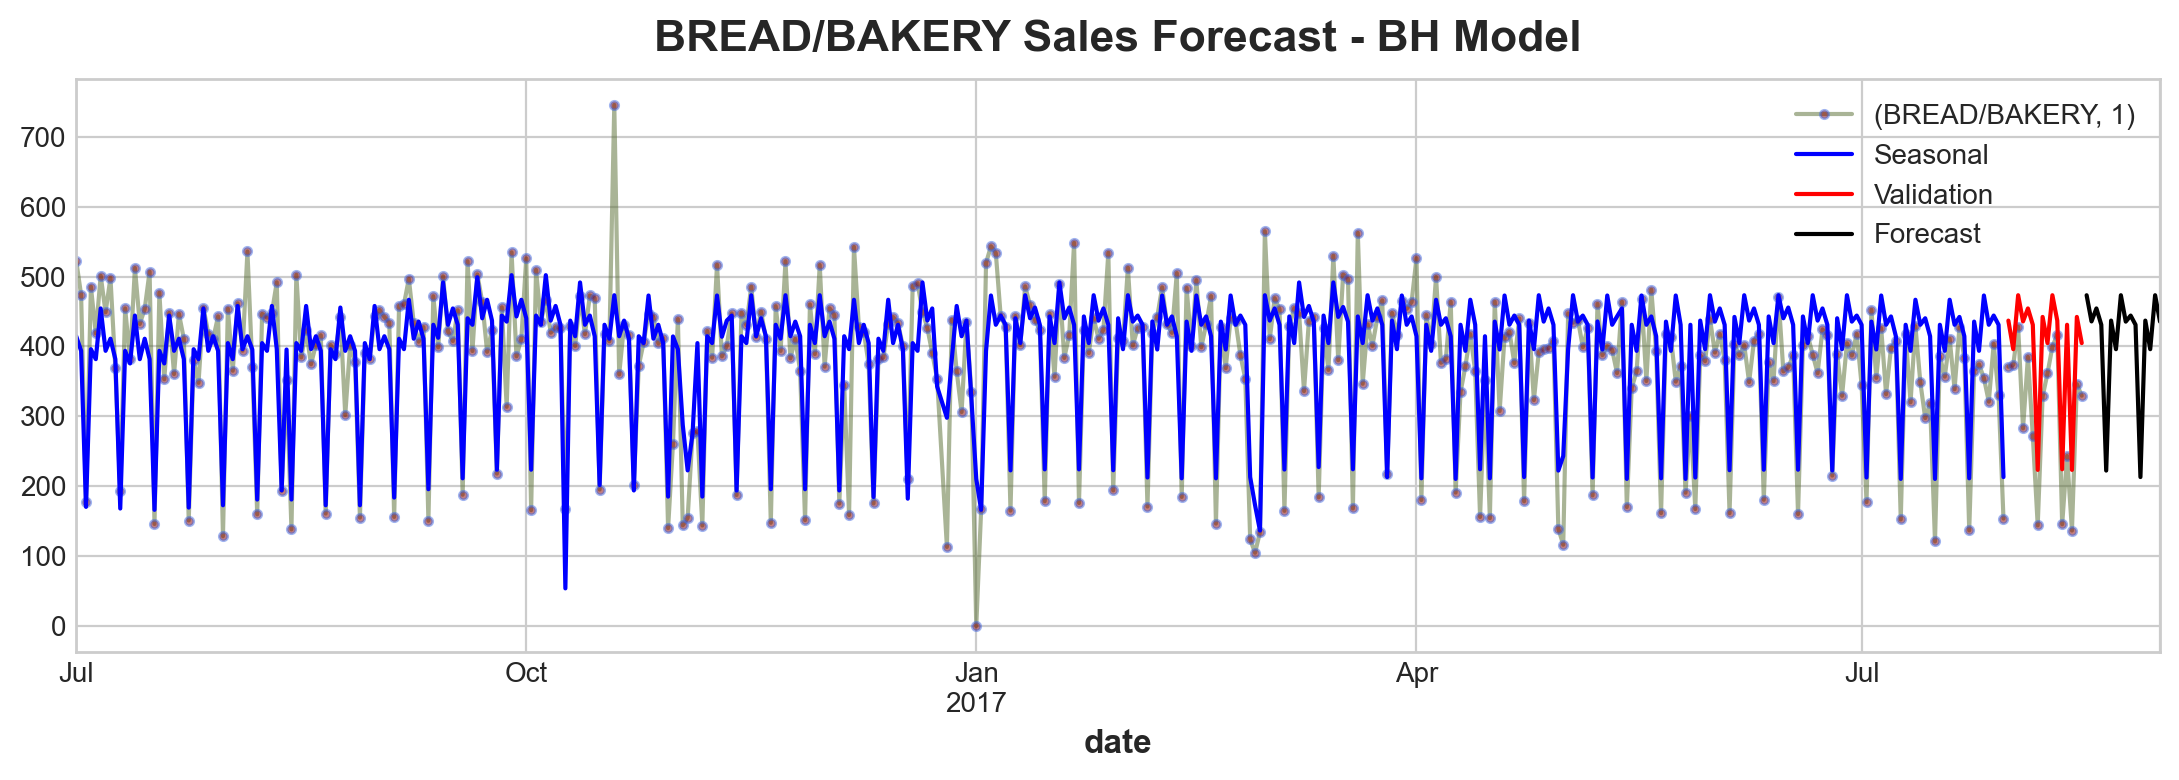

In [114]:
"""
Visualizing Seasonal against sales 
"""
# plot 'BREAD/BAKERY' as an example, as it has more frequent sales.
ax = y_train.loc["2016-07-01":, ('BREAD/BAKERY', 1)].plot(**plot_params, alpha=0.5)
(y_stacked_hybrid_fit.unstack(level=[1,2])).loc["2016-07-01":, ('BREAD/BAKERY', 1)].plot(ax=ax, color="blue", label="Seasonal")
y_val.loc[:, ('BREAD/BAKERY', 1)].plot(**plot_params, ax=ax, alpha=0.5, label="")
y_SH_val.unstack(level=[1,2]).loc[:, ('BREAD/BAKERY', 1)].plot(ax=ax, color="red", label ="Validation")
y_SH_test.unstack(level=[1,2]).loc[:, ('BREAD/BAKERY', 1)].plot(ax=ax, color="black", label= "Forecast")
ax.set_title (f'BREAD/BAKERY Sales Forecast - BH Model')
ax.legend()

In [ ]:
# submission_3 = (y_stacked_hybrid
#             .to_frame()
#             .join(test.id)
#             .rename(columns = {0:'sales'})
#             .reset_index(drop=True)
#             .reindex(columns = ['id','sales'])
#             )
# # submission_2.to_csv('/kaggle/working/submission.csv', index=False)

### 5).STRATEGY IV: Facebook Prophet

In this section, we are going to use [Prophet](https://facebook.github.io/prophet/). Prophet is an open-source forecasting procedure developed by Meta.  

Prophet will allow us to fit the model, not only with the sales volume but also with holidays and promotions. That **may** help improve the model predictions.

But Prophet can't support multi-index data. Here I'll try one pair(one family in one store) as an example first, Then I'll train 54 X 33 = 1782 Prophet models separately.

In [10]:
# Reset the index and move 'date' back to a column
holidays_events.reset_index(drop=False, inplace=True)

# Let's create a new dataframe that will map the holidays to the stores
holidays_stores_national_df = holidays_events[holidays_events['locale']=='National'].merge(stores,how='cross')[['store_nbr','date']]
holidays_stores_regional_df = holidays_events[holidays_events['locale']=='Regional'].merge(stores,how='inner',left_on='locale_name',right_on='state')[['store_nbr','date']]
holidays_stores_city_df = holidays_events[holidays_events['locale']=='Local'].merge(stores,how='inner',left_on='locale_name',right_on='city')[['store_nbr','date']]
holidays_stores_df = pd.concat([holidays_stores_national_df, holidays_stores_regional_df, holidays_stores_city_df]).drop_duplicates().sort_values('date').reset_index(drop=True)

holidays_stores_df[['date','store_nbr']].head()

date  store_nbr
0  2012-03-02         52
1  2012-03-02         53
2  2012-04-01         12
3  2012-04-01         13
4  2012-04-12         37

In [11]:
# prepare "promotions" for the train and test data
all_data = pd.concat([train, test], axis=0)
promotions = all_data["onpromotion"]

In [12]:
def model_Prophet(family='BREAD/BAKERY',store=1):
    # A function to forcast sales with Prophet for each (store,family) pair

    # Prophet requires the tain dataframe to have columns "ds" and "y" with the dates and values respectively
    Xp_train = pd.DataFrame()
    Xp_train['ds']=X_train.index.get_level_values('date').unique()
    Xp_train['y']=X_train.loc[(slice(None), family, store), "sales"].values
    Xp_train['ds'] = Xp_train['ds'].dt.to_timestamp()

    # Add an extra regressor in our sales forecast to consider the promotions.  
    Xp_train['onpromotion']=X_train.loc[(slice(None), family, store), "onpromotion"].values
   
    # Prophet requires that holiday has two columns (holiday and ds) to show holiday occurrence for this store. 
    holidays_prophet = pd.DataFrame({
        'holiday': 'holiday',
        'ds': holidays_stores_df[holidays_stores_df['store_nbr']== store]['date'].values,
    })
    holidays_prophet['ds'] =holidays_prophet['ds'].dt.to_timestamp()
  
    # instantiate a new Prophet object and fit the model
    m = Prophet(holidays=holidays_prophet)
    m.add_regressor('onpromotion')
    m.fit(Xp_train)
    
    #prepare validation X and predict X via make_future_dataframe
    yp_val = y_val.loc[slice(None)][family, store]
    # create a dataframe which will also include the dates from the history by default.
    future = m.make_future_dataframe(periods=len(yp_val)*2)
    
    # Adding the promotions to the future dataframe.  
    future['onpromotion']= promotions.loc[(slice(None), family, store)].values      
    
    # Calculate the predictions: a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.    
    preds = m.predict(future)
    preds['yhat']=preds['yhat'].apply(lambda x: max(x, 0)) # just in case as we can not have negative sales 
    preds = preds.set_index('ds').sort_index() 

    # Evaluate the model performance 
    rmsle_val = mean_squared_log_error(yp_val, preds['2017-07-31': '2017-08-15']['yhat'], squared=False)
    # preds.loc[(preds['ds']<= '2017-08-15') & (preds['ds']>='2017-07-31')]

    return store, family, m, Xp_train, preds, rmsle_val

08:06:31 - cmdstanpy - INFO - Chain [1] start processing
08:06:31 - cmdstanpy - INFO - Chain [1] done processing


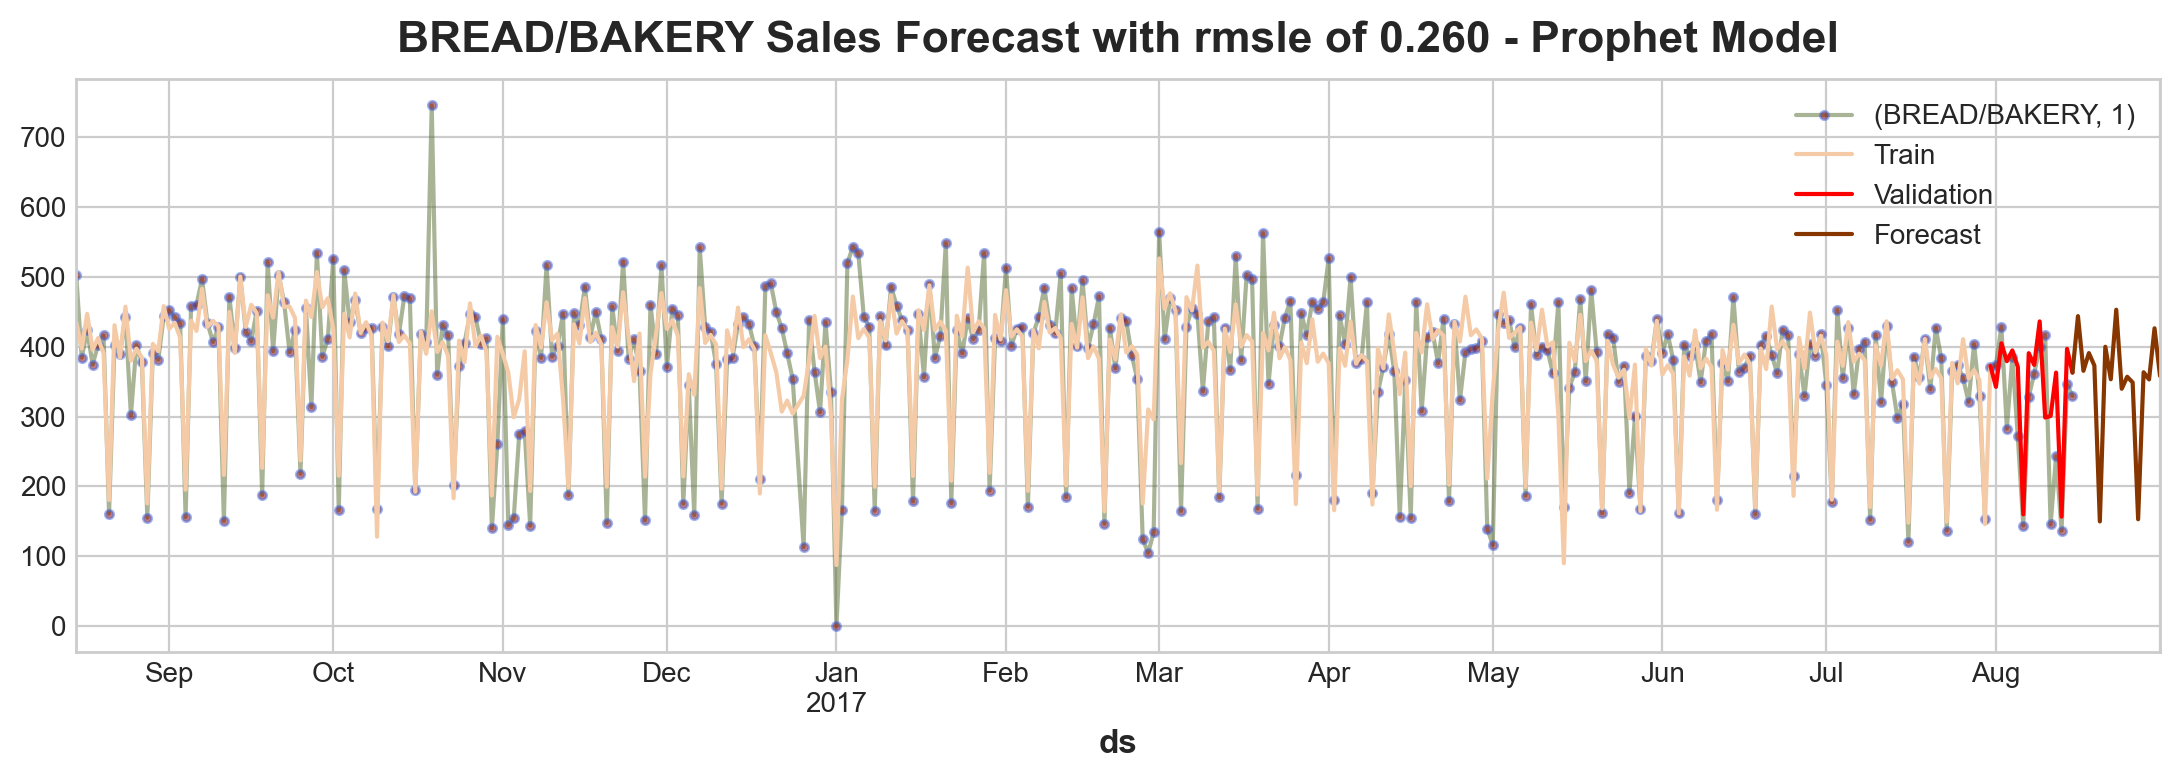

In [16]:
store, family, m, Xp_train, preds, rmsle_val = model_Prophet()
"""
Visualizing Validation against sales 
"""
# plot 'BREAD/BAKERY' as an example, as it has more frequent sales.
ax = y_train.loc['2016-08-15':, (family, store)].plot(**plot_params, alpha=0.5)
# y_train_pred.loc["2016-07-01":, (family, store)].plot(ax=ax, color="blue", label="Seasonal")
y_val.loc[:, (family, store)].plot(**plot_params, ax=ax, alpha=0.5, label="")
# preds = preds.set_index('ds') 
preds['2016-08-15':'2017-07-31']["yhat"].plot(ax=ax, color="#F5CBA7", label ="Train")
preds['2017-07-31':'2017-08-15']["yhat"].plot(ax=ax, color="red", label ="Validation")
preds['2017-08-15':]["yhat"].plot(ax=ax, color="#873600", label= "Forecast")
ax.set_title (f'{family} Sales Forecast with rmsle of {rmsle_val:.3f} - Prophet Model')
ax.legend()

In [319]:
# Forecast each family in each store 
y_train_pred = y_train.copy()
y_val_pred = y_val.copy()
y_test = X_test.copy()
y_test["sales"] = 0
y_test_pred = y_test.unstack(['family', 'store_nbr']).loc[:,"sales"]


for f in y_train.columns.get_level_values('family').unique():
    for s in range(1, 55):
        _, _, _, _, preds, _ = model_Prophet(f, s)

        mask_t = preds[:'2017-07-30']
        mask_v = preds['2017-07-31':'2017-08-15']
        mask_p = preds['2017-08-16':]

        y_train_pred.loc[:, (f, s)]=mask_t['yhat'].values
        y_val_pred.loc[:, (f, s)]=mask_v['yhat'].values
        y_test_pred.loc[:, (f, s)]=mask_p['yhat'].values

23:21:45 - cmdstanpy - INFO - Chain [1] start processing
23:21:45 - cmdstanpy - INFO - Chain [1] done processing
23:21:46 - cmdstanpy - INFO - Chain [1] start processing
23:21:46 - cmdstanpy - INFO - Chain [1] done processing
23:21:47 - cmdstanpy - INFO - Chain [1] start processing
23:21:48 - cmdstanpy - INFO - Chain [1] done processing
23:21:49 - cmdstanpy - INFO - Chain [1] start processing
23:21:49 - cmdstanpy - INFO - Chain [1] done processing
23:21:50 - cmdstanpy - INFO - Chain [1] start processing
23:21:50 - cmdstanpy - INFO - Chain [1] done processing
23:21:51 - cmdstanpy - INFO - Chain [1] start processing
23:21:52 - cmdstanpy - INFO - Chain [1] done processing
23:21:53 - cmdstanpy - INFO - Chain [1] start processing
23:21:53 - cmdstanpy - INFO - Chain [1] done processing
23:21:54 - cmdstanpy - INFO - Chain [1] start processing
23:21:54 - cmdstanpy - INFO - Chain [1] done processing
23:21:55 - cmdstanpy - INFO - Chain [1] start processing
23:21:56 - cmdstanpy - INFO - Chain [1]

In [304]:
mean_squared_log_error(y_val[:]['BREAD/BAKERY', 1], y_val_pred[:]['BREAD/BAKERY', 1]) ** 0.5

0.2599806253155626

In [320]:
rmsle_train = mean_squared_log_error(y_train, y_train_pred) ** 0.5
rmsle_train

1.0122710145251195

In [321]:
rmsle_val = mean_squared_log_error(y_val, y_val_pred) ** 0.5
rmsle_val

0.49423104813739854

In [ ]:
# submission_3 = (y_test_pred
#             .stack(['family', 'store_nbr'])
#             .to_frame()
#             .join(test.id)
#             .rename(columns = {0:'sales'})
#             .reset_index(drop=True)
#             .reindex(columns = ['id','sales'])
#             )
# # submission_3.to_csv('/kaggle/working/submission.csv', index=False)

## 4.Future Work
There is still room for improvement. In future work, I will consider:<br>
- 1). features:classify family to different groups: new-added family, seasonal family; Separate new-opened store from others; consider oil_price feature affects
- 2). algorithms: ARIMA model, Deep Learning
- 3). time period: use data after "2016-07-01" for training. Additionally, include validation data during training when predicting on the test set.